<a href="https://colab.research.google.com/github/RenukaSiriwardhana/Fabric-Defect-Detection-YOLOv8/blob/main/yolov8(experiment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import torch

# 1. GPU Check
if torch.cuda.is_available():
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU Unavailable. Change Runtiime to T4.")

# 2. Cleaning Old Runs
if os.path.exists('/content/runs'):
    shutil.rmtree('/content/runs')
    print("🧹 old Results cleaned.")

# 3. Installing YOLO
!pip install ultralytics
print("✅ Setup Complete.")

❌ GPU Unavailable. Change Runtiime to T4.
🧹 old Results cleaned.
✅ Setup Complete.


In [ ]:
from google.colab import drive
import glob
import random
import os
import shutil

# --- 1. Connect Google Drive
drive.mount('/content/drive')

# --- 2. Find Dataset Zip
# Looking for zip files in Fabric_Project folder
zip_files = glob.glob("/content/drive/MyDrive/Fabric_Project/*.zip")

if not zip_files:
    print("❌ Zip file not found! ")
else:
    source_zip = zip_files[0]
    # Define where to extract
    output_dir = '/content/datasets/fabric_paper_exp'

    # Clean existing dataset folder
    if os.path.exists(output_dir): shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    print("📦 Unzipping... ")
    # Unzip quietly
    os.system(f'unzip -q "{source_zip}" -d {output_dir}/temp')

    # --- 3. Create YOLO Folders
    # Creating train/val folders for images and labels /
    for split in ['train', 'val']:
        for dtype in ['images', 'labels']:
            os.makedirs(f'{output_dir}/{split}/{dtype}', exist_ok=True)

    # --- 4. Function to Convert Labels
    def convert_grid_to_yolo(txt_path, img_w, img_h):
        # Read the text file
        with open(txt_path, 'r') as f: lines = f.readlines()
        yolo_lines = []

        # Check if file has data (skip headers)
        if len(lines) > 5:
            start_line = 5
            rows = 16
            cols = 16
            # Calculate block size
            block_w = img_w / cols
            block_h = img_h / rows

            for r in range(rows):
                if start_line + r >= len(lines): break
                data = lines[start_line + r].strip().split()
                for c in range(cols):
                    # If '1' is found, it's a defect
                    if c < len(data) and data[c] == '1':
                        # Calculate center x, y and width, height
                        x_center = (c * block_w + block_w/2) / img_w
                        y_center = (r * block_h + block_h/2) / img_h
                        w_norm = block_w / img_w
                        h_norm = block_h / img_h
                        # Add to list
                        yolo_lines.append(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")
        return yolo_lines

    # --- 5. Split and Process Data
    # Find all images
    all_images = glob.glob(f"{output_dir}/temp/**/*.png", recursive=True) + \
                 glob.glob(f"{output_dir}/temp/**/*.jpg", recursive=True)

    # Shuffle the list
    random.shuffle(all_images)

    # 80% for Training
    split_idx = int(len(all_images) * 0.8)
    train_imgs = all_images[:split_idx]
    val_imgs = all_images[split_idx:]

    print("⚙️ Processing Images & Labels... ")

    def process_files(file_list, split):
        for img_path in file_list:
            # Copy image to new folder
            shutil.copy(img_path, f'{output_dir}/{split}/images/')

            # Find corresponding text file
            txt_path = img_path.replace('.png', '.txt').replace('.jpg', '.txt')
            if os.path.exists(txt_path):
                # Convert label to YOLO format
                # TFD dataset original size is approx 256x256
                yolo_data = convert_grid_to_yolo(txt_path, 256, 256)

                # Save new label file
                label_save_path = f'{output_dir}/{split}/labels/' + os.path.basename(txt_path)
                with open(label_save_path, 'w') as f:
                    f.write('\n'.join(yolo_data))

    # Process both sets
    process_files(train_imgs, 'train')
    process_files(val_imgs, 'val')

    # --- 6. Create YAML Config
    yaml_content = f"""
path: {output_dir}
train: train/images
val: val/images
names:
  0: Defect
"""
    with open(f'{output_dir}/data.yaml', 'w') as f:
        f.write(yaml_content)

    print("✅ Dataset Ready for Training!")

Mounted at /content/drive
📦 Unzipping... 
⚙️ Processing Images & Labels... 
✅ Dataset Ready for Training!


In [ ]:


# 1. Install YOLO library
print("⏳ Installing Ultralytics...")
!pip install ultralytics

# 2. Import Libraries
import os
import shutil
from ultralytics import YOLO

print("✅ Installation Complete!")

# 3. Check for Dataset (If not found, we need to unzip it again)

dataset_path = '/content/datasets/fabric_paper_exp'

if not os.path.exists(dataset_path):
    print("🔍 Dataset not found. Unzipping now...")

    # NOTE: Upload your 'fabric_paper_exp.zip' file to Colab first if it's missing!

    zip_path = '/content/fabric_paper_exp.zip'

    if os.path.exists(zip_path):
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('/content/datasets')
        print("✅ Dataset extracted successfully!")
    else:
        print("❌ Error: 'fabric_paper_exp.zip' not found!")
        print("Please upload the zip file to Colab Files section first.")

else:
    print("✅ Dataset is ready!")

⏳ Installing Ultralytics...
✅ Installation Complete!
✅ Dataset is ready!


In [ ]:
# --- Step 2: Run Experiment 2 (SGD Optimizer) ---

from ultralytics import YOLO

# Load the model
model = YOLO('yolov8n.pt')

print("🚀 Starting Experiment 2 (SGD Optimizer)...")

# Start Training
results = model.train(
    data='/content/datasets/fabric_paper_exp/data.yaml',
    epochs=100,
    batch=16,
    imgsz=640,
    optimizer='SGD',     # <-- The Secret Weapon
    lr0=0.01,
    momentum=0.937,
    project='/content/runs/detect',
    name='Paper_Reproduction_Exp2_SGD',
    verbose=True
)

🚀 Starting Experiment 2 (SGD Optimizer)...
Ultralytics 8.3.243 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/fabric_paper_exp/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Paper_Reproduction_Exp2_SGD, nbs=64, nms=False, opset=None, optimize=False, op

In [ ]:
from google.colab import files
import os

# The name of our successful experiment
exp_name = 'Paper_Reproduction_Exp2_SGD'

print(f"📥 Downloading files for {exp_name}...")

# 1. Download Model Weights (The Brain)
file_path_model = f'/content/runs/detect/{exp_name}/weights/best.pt'
if os.path.exists(file_path_model):
    files.download(file_path_model)
else:
    print("⚠️ best.pt not found!")

# 2. Download Results Data (The Proof)
file_path_results = f'/content/runs/detect/{exp_name}/results.csv'
if os.path.exists(file_path_results):
    files.download(file_path_results)
else:
    print("⚠️ results.csv not found!")

📥 Downloading files for Paper_Reproduction_Exp2_SGD...
⚠️ best.pt not found!
⚠️ results.csv not found!


In [ ]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- 1. Settings
# Put your image name here
my_image_name = "test.PNG"

image_path = f"/content/{my_image_name}"

# Path to our new SGD Model (The successful one)
model_path = '/content/runs/detect/Paper_Reproduction_Exp2_SGD/weights/best.pt'

# --- 2. Check & Predict
if os.path.exists(model_path):
    print(f"🚀 Testing with SGD Model: {model_path}")

    if os.path.exists(image_path):
        # Load the model
        model = YOLO(model_path)

        # Predict (Using a lower confidence threshold to catch errors)
        results = model.predict(source=image_path, save=True, conf=0.15)

        # --- 3. Show Result
        # Find the latest prediction folde
        predict_folders = glob.glob('/content/runs/detect/predict*')
        if predict_folders:
            latest_predict = max(predict_folders, key=os.path.getmtime)

            # Find the saved image
            file_name_no_ext = os.path.splitext(my_image_name)[0]
            found_files = glob.glob(os.path.join(latest_predict, file_name_no_ext + ".*"))

            if found_files:
                print("\n👇 Detection Result (SGD Model):")
                display(Image(filename=found_files[0], width=600))
            else:
                print("⚠️ Result image not found.")
        else:
            print("❌ No prediction folders found. ")

    else:
        print(f"❌ Image '{my_image_name}' not found! Please upload it to Colab.")
else:
    print("❌ Model file not found! Did Exp 2 finish correctly?")


In [ ]:

print("⏳ Installing Ultralytics...")
!pip install ultralytics
print("✅ Installation Complete!")

⏳ Installing Ultralytics...
✅ Installation Complete!


In [ ]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display


my_image_name = "TEST.PNG"

model_file_name = "best.pt"

# Paths in Colab
image_path = f"/content/{my_image_name}"
model_path = f"/content/{model_file_name}"

# --- Prediction Logic ---
if os.path.exists(model_path) and os.path.exists(image_path):
    print(f"🚀 Loading model from {model_file_name}...")

    # Load your saved model
    model = YOLO(model_path)

    print(f"🕵️ Detecting defects in {my_image_name} using CPU...")

    # Run prediction (Force CPU usage)
    results = model.predict(
        source=image_path,
        save=True,
        conf=0.25,
        device='cpu'
    )

    # --- Show Result ---
    predict_folders = glob.glob('/content/runs/detect/predict*')
    if predict_folders:
        latest_predict = max(predict_folders, key=os.path.getmtime)
        found_files = glob.glob(os.path.join(latest_predict, "*"))

        # Filter for our image (ignoring case just to be safe this time)
        target_file = [f for f in found_files if my_image_name in f]

        if target_file:
            print("\n👇 Detection Result (From your saved model):")
            display(Image(filename=target_file[0], width=400))
        else:
            print("⚠️ Result image not found.")
    else:
        print("❌ Prediction failed to save.")

else:
    print(f"❌ Error: We can't find '{my_image_name}' or '{model_file_name}'")
    print(f"Check if the file is named 'TEST.png' or 'TEST.PNG' exactly.")

🚀 Loading model from best.pt...
🕵️ Detecting defects in TEST.PNG using CPU...

image 1/1 /content/TEST.PNG: 352x640 (no detections), 259.9ms
Speed: 18.9ms preprocess, 259.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)
Results saved to /content/runs/detect/predict
⚠️ Result image not found.


🚀 Trying with very low confidence (0.05)...

image 1/1 /content/TEST.PNG: 352x640 118 Defects, 139.9ms
Speed: 3.9ms preprocess, 139.9ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
Results saved to /content/runs/detect/predict3

👇 Low Confidence Result:


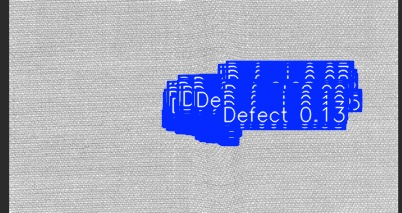

In [ ]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- Settings ---
my_image_name = "TEST.PNG"
model_file_name = "best.pt"

image_path = f"/content/{my_image_name}"
model_path = f"/content/{model_file_name}"

if os.path.exists(model_path) and os.path.exists(image_path):
    print(f"🚀 Trying with very low confidence (0.05)...")

    model = YOLO(model_path)

    # Lower confidence to 0.05 (5%)
    results = model.predict(
        source=image_path,
        save=True,
        conf=0.05,      # <--- Very low threshold
        device='cpu'
    )

    # --- Show ANY Result ---
    predict_folders = glob.glob('/content/runs/detect/predict*')
    if predict_folders:
        latest_predict = max(predict_folders, key=os.path.getmtime)
        found_files = glob.glob(os.path.join(latest_predict, "*"))

        if found_files:
            print("\n👇 Low Confidence Result:")
            display(Image(filename=found_files[0], width=400))
        else:
            print("⚠️ Result saved but file listing failed.")
    else:
        print("❌ Prediction failed.")
else:
    print("❌ Check files again.")